## make_sbc:
### Make surface boundary conditions.
#### Version id:
#### v1.
#### ACCESS OM2-1

In [8]:
cd /g/data/jk72/deg581/se-qld-setup/notebooks

/g/data/jk72/deg581/se-qld-setup/notebooks


In [9]:
run ='seqld_1km'

import numpy as np 
import os
import sys
import xarray as xr
import scipy.io as sio
import matplotlib.pyplot as plt
import datetime
from scipy.interpolate import griddata
import glob

proj_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_dir = os.path.join(proj_dir,'data')
src_dir = os.path.join(proj_dir,'src')

sys.path.append(src_dir)


from ext.tools.NDinterp import NDinterp
from ext.tools.log_progress import log_progress


# set user parameter and call main routine
grd_file = os.path.join(data_dir,'proc','seqld_1km_grd.nc')

# Path to ECCO2 files for temperature and salinity 1th January 2007
# access_path = os.path.join(data_dir,'raw','access-om2/')
access_path = os.path.join('/g/data/ik11/outputs/access-om2-01/01deg_jra55v150_iaf_cycle1/')

access_sub_paths = ['./output196/ocean/','./output197/ocean/','./output198/ocean/','./output199/ocean/']
# access_sub_paths = ['./']


In [10]:
# Load ACCESS data

# sfc heat flux
## ...
file_list=[]
file_name_format = 'ocean-2d-net_sfc_heating-1-daily-mean-ym_2007_*.nc'
for subfolder in access_sub_paths:
    file_list = file_list+glob.glob(access_path+subfolder+file_name_format)
shflx_surf_full = xr.open_mfdataset(file_list,decode_times=True)

# frazil_integrated
## In ACCESS-OM2, the frazil heat flux is distributed in depth through the ocean (though mostly surface concentrated). 
##  The frazil_3d_int_z diagnostic is the vertical integral of this, which you could approximate as a surface flux.
file_list=[]
file_name_format = 'ocean-2d-frazil_3d_int_z-1-daily-mean-ym_2007_*.nc'
for subfolder in access_sub_paths:
    file_list = file_list+glob.glob(access_path+subfolder+file_name_format)
shflx_frazil_full = xr.open_mfdataset(file_list,decode_times=True)


# pme_river
## That includes all freshwater fluxes from the atmosphere, runoff and sea ice.
file_list=[]
file_name_format = 'ocean-2d-pme_river-1-daily-mean-ym_2007_*.nc'
for subfolder in access_sub_paths:
    file_list = file_list+glob.glob(access_path+subfolder+file_name_format)
pme_full = xr.open_mfdataset(file_list,decode_times=True)

# sfc_salt_flux_restore
## mass flux of salt from surface salinity 
file_list=[]
file_name_format = 'ocean-2d-sfc_salt_flux_restore-1-daily-mean-ym_2007_*.nc'
for subfolder in access_sub_paths:
    file_list = file_list+glob.glob(access_path+subfolder+file_name_format)
ssflx_restore_full = xr.open_mfdataset(file_list,decode_times=True)

# sfc_salt_flux_ice
## mass flux of salt from ice formation/melt
file_list=[]
file_name_format = 'ocean-2d-sfc_salt_flux_ice-1-daily-mean-ym_2007_*.nc'
for subfolder in access_sub_paths:
    file_list = file_list+glob.glob(access_path+subfolder+file_name_format)
ssflx_ice_full = xr.open_mfdataset(file_list,decode_times=True)


# x tau
file_list=[]
file_name_format = 'ocean-2d-tau_x-1-daily-mean-ym_2007_*.nc'
for subfolder in access_sub_paths:
    file_list = file_list+glob.glob(access_path+subfolder+file_name_format)
tau_x_full = xr.open_mfdataset(file_list,decode_times=True)

# y tau
file_list=[]
file_name_format = 'ocean-2d-tau_y-1-daily-mean-ym_2007_*.nc'
for subfolder in access_sub_paths:
    file_list = file_list+glob.glob(access_path+subfolder+file_name_format)
tau_y_full = xr.open_mfdataset(file_list,decode_times=True)

In [11]:
ssflx_ice_full

<xarray.Dataset>
Dimensions:            (xt_ocean: 3600, yt_ocean: 2700, time: 365, nv: 2)
Coordinates:
  * xt_ocean           (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.85 79.95
  * yt_ocean           (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.94 89.98
  * time               (time) datetime64[ns] 2007-01-01T12:00:00 ... 2007-12-...
  * nv                 (nv) float64 1.0 2.0
Data variables:
    sfc_salt_flux_ice  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(90, 2700, 3600), meta=np.ndarray>
    average_T1         (time) datetime64[ns] dask.array<chunksize=(90,), meta=np.ndarray>
    average_T2         (time) datetime64[ns] dask.array<chunksize=(90,), meta=np.ndarray>
    average_DT         (time) timedelta64[ns] dask.array<chunksize=(90,), meta=np.ndarray>
    time_bnds          (time, nv) timedelta64[ns] dask.array<chunksize=(90, 2), meta=np.ndarray>
Attributes:
    filename:   ocean-2d-sfc_salt_flux_ice-1-daily-mean-ym_2007_01.nc
    title:      ACCESS-OM2-01
    grid_type:  mosaic
    grid_tile:  1
    history:    20221106T0435Z: /g/data/ik11/inputs/access-om2/bin/mppnccombi...

In [12]:
## convert the ACCESS variables into the appropriate ROMS-specific surface fluxes

# surface heat flux is the combination of the net surface heat + the frazil vertically-integrated heat flux
#  units should be Heat/(rho0*Cp) = [W/m2]/[kg/m3 * J/kg/C] = [C m/s]
# BousDens = 1027.0
# CpWater = 3947.0 #ROMS default is 4000.
# Note that division by BousDens*CpWater is done internally in Utility/inp_par.F

shflux_full = (shflx_surf_full.net_sfc_heating+shflx_frazil_full.frazil_3d_int_z)
shflux_full.attrs['filename']=shflx_surf_full.attrs['filename']+','+shflx_frazil_full.attrs['filename']
shflux_full.attrs['history']='(net_sfc_heating+frazil_3d_int_z)'
# freshwater flux is combination of E-P, Rivers, combined with salt fluxes. Note that salt fluxes must be converted to 
#  equivalent freshwater fluxes. Sign/directionality between ACCESS and ROMS must also be accounted for. ROMS wants E-P,
#  so a positive value is evaporating/adding salt.
#  units of freshwater flux are (E-P) /rho_water = [kg/m2/s]/[kg/m3] = [m/s]
#  units of salt flux are (SALT*E-P) / rho_water = {PSU}* [m/s]
#  Freshwater flux is defined as *POSITIVE UP*, that is E-P.
#  note that freshwater flux is converted -> saltwater flux in set_vbc.F.
#  likewise, a salt flux needs to be converted first to a freshwater flux by dividing by a surface salinity.
#  note: also, previously roms might have wanted cm/d, but now requirement is m/s.
refSalt = 34.4
refDens = 1000 #reference density of freshwater (1000km/m3)
swflux_full = -(pme_full.pme_river/refDens + (ssflx_restore_full.sfc_salt_flux_restore + ssflx_ice_full.sfc_salt_flux_ice)/refSalt )
swflux_full.attrs['filename']=pme_full.attrs['filename']+','+ssflx_restore_full.attrs['filename']+','+ssflx_ice_full.attrs['filename']
swflux_full.attrs['history']='-(pme_river/refDens + (sfc_salt_flux_restore + sfc_salt_flux_ice)/refSalt )'

In [13]:
shflx_surf_full.net_sfc_heating

<xarray.DataArray 'net_sfc_heating' (time: 365, yt_ocean: 2700, xt_ocean: 3600)>
dask.array<concatenate, shape=(365, 2700, 3600), dtype=float32, chunksize=(92, 2700, 3600), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * time      (time) datetime64[ns] 2007-01-01T12:00:00 ... 2007-12-31T12:00:00
Attributes:
    long_name:      surface ocean heat flux coming through coupler and mass t...
    units:          Watts/m^2
    valid_range:    [-10000.  10000.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_t geolat_t

In [14]:
grid = xr.open_dataset(grd_file)


grd_lon_ax = np.array((grid.lon_rho.min().values*0.9, grid.lon_rho.max().values*1.1))
grd_lat_ax = np.array((grid.lat_rho.min().values*1.1, grid.lat_rho.max().values*0.9))

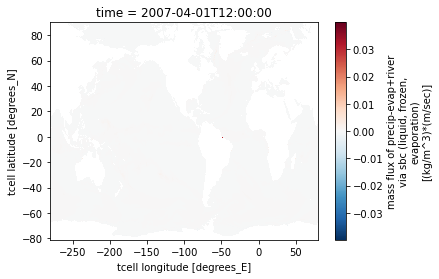

In [19]:
pme_full.pme_river.isel(time=90).plot()

TypeError: can only concatenate tuple (not "int") to tuple

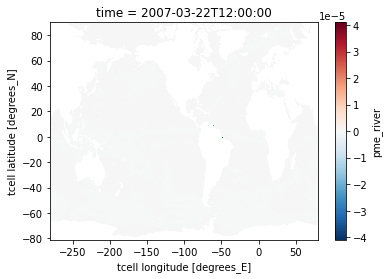

In [20]:

plt.contour((grid.lon_rho),grid.lat_rho,grid.mask_rho,levels=np.array((-1,0)),colors='k',zorder=10)
((-pme_full.pme_river/refDens).isel(time=80)).plot(cmap='RdBu_r')
plt.xlim(((150,160)+360))
plt.ylim((-31,-23))
plt.title('-pme_river/1000')
plt.show()


#### TRYING TO GET PLOT TO WORK - COORDINATES ARE WRAPPED!

plt.contour((grid.lon_rho),grid.lat_rho,grid.mask_rho,levels=np.array((-1,0)),colors='k',zorder=10)
(-((ssflx_restore_full.sfc_salt_flux_restore)/refSalt).isel(time=80)).plot(cmap='RdBu_r')
plt.xlim((150,160))
plt.ylim((-31,-23))
plt.title('-sfc_salt_flux_restore/refSalt')
plt.show()


plt.contour(grid.lon_rho+360,grid.lat_rho,grid.mask_rho,levels=np.array((-1,0)),colors='k',zorder=10)
(-((ssflx_ice_full.sfc_salt_flux_ice)/refSalt).isel(time=80)).plot(cmap='RdBu_r')
plt.xlim((150,160))
plt.ylim((-31,-23))
plt.title('-sfc_salt_flux_ice/refSalt')
plt.show()




plt.contour(grid.lon_rho,grid.lat_rho,grid.mask_rho,levels=np.array((-1,0)),colors='k',zorder=10)
(-((ssflx_restore_full.sfc_salt_flux_restore + ssflx_ice_full.sfc_salt_flux_ice)/refSalt).isel(time=80)).plot(cmap='RdBu_r')
plt.xlim((150,160))
plt.ylim((-31,-23))
plt.title('- (sfc_salt_flux_restore + sfc_salt_flux_ice)/refSalt')
plt.show()


plt.contour(grid.lon_rho,grid.lat_rho,grid.mask_rho,levels=np.array((-1,0)),colors='k',zorder=10)
(swflux_full.isel(time=80)).plot(cmap='RdBu_r')
plt.xlim((150,160))
plt.ylim((-31,-23))
plt.title('- (pme_river/1000 + (sfc_salt_flux_restore + sfc_salt_flux_ice)/refSalt)')
plt.show()


#### understanding directionality:
 ###### salt flux is positive down, so positive value adds salt, reduce freshwater
 ###### so freshwater flux is positive up, so a positive value moves freshwater out of the model.

 ###### alternatively,  salt flux is positive in. positive adds salt
 ###### likewise, freshwater flux is positive out. so positive removes freshwater.
 ###### Both views are consistent.
 ###### swflux/ssflux > 0 ==> addition of salt/removal of freshwater (evaporation, freezing)
 ###### swflux/ssflux < 0 ==> removal of salt/addition of freshwater (precipitation, melting)

In [ ]:
tau_x_full

In [ ]:
#load roms grid and convert lon to 0-360

R_grid = xr.open_dataset(grd_file)
R_lon = R_grid.lon_rho.values
R_lat = R_grid.lat_rho.values
R_angle = R_grid.angle.values
R_ulon = R_grid.lon_u.values
R_vlon = R_grid.lon_v.values
R_ulat = R_grid.lat_u.values
R_vlat = R_grid.lat_v.values


R_lon[R_lon<0]+=360
R_ulon[R_ulon<0]+=360
R_vlon[R_vlon<0]+=360

In [ ]:
# We need to roll the x-coordinate and sort by x so that the seam is not over the ROI.
ds_new = tau_x_full.assign_coords({'xu_ocean': (tau_x_full['xu_ocean'] + 360) % 360})
ds_new.tau_x.sortby('xu_ocean').isel(time=0).plot()

In [ ]:
# remap the x-coordinate so that hte model seam doesn't cross the ROI.
print('re-mapping')
tau_x_full = tau_x_full.assign_coords({'xu_ocean': (tau_x_full['xu_ocean'] + 360) % 360})
tau_y_full = tau_y_full.assign_coords({'xu_ocean': (tau_y_full['xu_ocean'] + 360) % 360})
shflx_full = shflux_full.assign_coords({'xt_ocean': (shflux_full['xt_ocean'] + 360) % 360})
swflx_full = swflux_full.assign_coords({'xt_ocean': (swflux_full['xt_ocean'] + 360) % 360})

#access wind data is already daily data. So just crop to required geog limits:
print('subsetting')
tau_x_temporary = tau_x_full.sortby('xu_ocean').sel(yu_ocean=slice(*grd_lat_ax),xu_ocean=slice(*grd_lon_ax))
tau_y_temporary = tau_y_full.sortby('xu_ocean').sel(yu_ocean=slice(*grd_lat_ax),xu_ocean=slice(*grd_lon_ax))
shflx_temporary = shflx_full.sortby('xt_ocean').sel(yt_ocean=slice(*grd_lat_ax),xt_ocean=slice(*grd_lon_ax))
swflx_temporary = swflx_full.sortby('xt_ocean').sel(yt_ocean=slice(*grd_lat_ax),xt_ocean=slice(*grd_lon_ax))
tau_x_temporary.tau_x.isel(time=0).plot()


#get access coordinates
t_lon,t_lat = shflx_temporary.xt_ocean.values,shflx_temporary.yt_ocean.values
u_lon,u_lat = tau_x_temporary.xu_ocean.values,tau_x_temporary.yu_ocean.values
t_lon_2d,t_lat_2d = np.meshgrid(t_lon,t_lat)
u_lon_2d,u_lat_2d = np.meshgrid(u_lon,u_lat)
t_lon_flat,t_lat_flat = t_lon_2d.flatten(),t_lat_2d.flatten()
u_lon_flat,u_lat_flat = u_lon_2d.flatten(),u_lat_2d.flatten()

In [ ]:
# #define regridding functions for era and tamura data
# # griddata takes flat arrays of source points and data and interpolates to 2d grid
        

# def regrid_tamura(slon,slat,sdat,tlon,tlat):
    
#     slon = slon[slat<(tlat.max()+2)] # only load data up to 2 deg further north of roms highest latitude
#     sdat = sdat[slat<(tlat.max()+2)]
#     slat = slat[slat<(tlat.max()+2)]
    
#     #tamura comes from npstereo curvilinear grid
#     #we need to find points close to the 0/360 gap, wrap them and add them to the list for source points
#     # otherwise we get an interpolation gap between 0/360
    
#     ii1 = (slon<2.0)

#     slon_ext1 = slon[ii1]
#     slon_ext1[slon_ext1<=1]+=360

#     ii2 = (slon>358.0)

#     slon_ext2 = slon[ii2]
#     slon_ext2[slon_ext2>=359]-=360
    
#     slon_ext = np.hstack((slon_ext1,slon_ext2))
#     slat_ext = np.hstack((slat[ii1],slat[ii2]))
#     sdat_ext = np.hstack((sdat[ii1],sdat[ii2]))
      
#     slon = np.hstack((slon,slon_ext))
#     slat = np.hstack((slat,slat_ext))
#     sdat = np.hstack((sdat,sdat_ext))

#     tdat =griddata((slon,slat),sdat,(tlon,tlat),'cubic')
    
#     return tdat

In [ ]:
# define inpaint_nans
from scipy.signal import convolve2d
def inpaint_nans(inField):
    im = inField.copy()
    import scipy
    ipn_kernel = np.array([[1,1,1],[1,0,1],[1,1,1]]) # kernel for inpaint_nans
    nans = np.isnan(im)
    while np.sum(nans)>0:
        im[nans] = 0
        vNeighbors = convolve2d((nans==False),ipn_kernel,mode='same',boundary='symm')
        im2 = convolve2d(im,ipn_kernel,mode='same',boundary='symm')
        im2[vNeighbors>0] = im2[vNeighbors>0]/vNeighbors[vNeighbors>0]
        im2[vNeighbors==0] = np.nan
        im2[(nans==False)] = im[(nans==False)]
        im = im2
        nans = np.isnan(im)
    return im


In [ ]:
def regrid_access(slon,slat,sdat,tlon,tlat):
    tdat =griddata((slon,slat),sdat,(tlon,tlat),'cubic')
        
    return tdat    

In [ ]:
# load the variables that I will need to load each time within the loop
R_grid.load(),print('loaded')
swflx_temporary.load(),print('loaded')
shflx_temporary.load(),print('loaded')
tau_x_temporary.load(),print('loaded')
tau_y_temporary.load(),print('loaded')


In [ ]:
# MAKE THE MAGIC HAPPEN FOR 2007 AND save in interim folder
month = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
month_nb = ['01','02','03','04','05','06','07','08','09','10','11','12']
daysPerMonth = [31,28,31,30,31,30,31,31,30,31,30,31]

#month = ['nov']
#month_nb = ['11']
#daysPerMonth = [30]

#month = ['jan']
#
#daysPerMonth = [1]

dayOfYear = 1

for month,days,month_nb in zip(month,daysPerMonth,month_nb):
    
    print('Processing month: ',month,'with days: ',days)
    
    daysOfYear = np.arange(dayOfYear,dayOfYear+days,dtype=int)
    
    print('Containing days of year: ',daysOfYear)

    # preparing empty dataset
    ds = xr.Dataset({'shflux':(['shf_time','eta_rho','xi_rho'], np.empty((days,R_grid.eta_rho.size,R_grid.xi_rho.size))),
                     'swflux':(['swf_time','eta_rho','xi_rho'], np.empty((days,R_grid.eta_rho.size,R_grid.xi_rho.size))),
                     'sustr':(['sms_time','eta_u','xi_u'], np.empty((days,R_grid.eta_u.size,R_grid.xi_u.size))),
                     'svstr':(['sms_time','eta_v','xi_v'], np.empty((days,R_grid.eta_v.size,R_grid.xi_v.size)))},
                   coords={'shf_time':(['shf_time'],daysOfYear),
                           'swf_time':(['swf_time'],daysOfYear),
                           'sms_time':(['sms_time'],daysOfYear)})
   
    
    #looping over the days with running day-of-the-year and day-of-the-month index
    for Eidx,Tidx in zip(log_progress(daysOfYear-1,name='days'),np.arange(days)):
        #Eidx continues through the year
        #Tidx repeats through the days of the months
        
        # select the daily data from the access data ds
        
        shflux_tmp = shflx_temporary.isel(time=Eidx) #load from the DOY index 
        swflux_tmp = swflx_temporary.isel(time=Eidx) # note this is a swflux not a ssflux
                
        # #read in Tamura heat and fresh water flux and turn in right position
        # shflux_tmp = np.flipud(T_data[0,Tidx])
        # ssflux_tmp = np.flipud(T_data[2,Tidx])
        
        # #fill in tamuar mask for later resampling
        # shflux_tmp[T_mask==0] = np.nan
        # shflux_tmp = NDinterp(shflux_tmp)
        
        # ssflux_tmp[T_mask==0] = np.nan
        # ssflux_tmp = NDinterp(ssflux_tmp)
        
        # shflux_tmp = regrid_tamura(T_lon,T_lat,shflux_tmp,R_lon,R_lat) 
        # ssflux_tmp = regrid_tamura(T_lon,T_lat,ssflux_tmp,R_lon,R_lat)
        
        # shflux_tmp[shflux_tmp > 0.0]*=0.5
        
        shflux_tmp = regrid_access(t_lon_flat,t_lat_flat,inpaint_nans(shflux_tmp.values).flatten(),R_lon,R_lat) 
        swflux_tmp = regrid_access(t_lon_flat,t_lat_flat,inpaint_nans(swflux_tmp.values).flatten(),R_lon,R_lat) 
        
        ds.shflux[Tidx] = shflux_tmp
        del shflux_tmp
        
        #convert to freshwater flux with convention positive up 'swf (E-P)',
        #that means a positive freshwater flux value results in positive salt flux value
        #and save to dataset
        # refSalt = 34.4
        # ds.swflux[Tidx] = ssflux_tmp/refSalt*100
        # del ssflux_tmp
        ## NOTE: Takeshi units must have ACTUALLY already been ssflux (E-P/rhow)*SALT
        ##  and so, there was a /refSalt to convert to a swflux value, which is then
        ##  internally scaled in set_vbc.F back to ssflux by *SALT.
        ##  However, access data is E-P, and so does not need to be divided by SALT.
        ##  Also note that ROMS now wants m/s as the input units, not m/day, so the
        ##  original E-P field should be divided by freshwater density (as done above),
        ##  and any ssflux fields (e.g. salt fluxes) should be /refSalt so as to be a
        ##  freshwater flux
        
        ds.swflux[Tidx] = swflux_tmp
        del swflux_tmp
        
        #select access stress fields
        taux = tau_x_temporary.tau_x.isel(time=Eidx).values
        tauy = tau_y_temporary.tau_y.isel(time=Eidx).values
        
        #rotate wind directions to roms grid
        uv = (taux+1j*tauy)*np.exp(1j*-(u_lon_2d/180*np.pi))
        taux_rot = uv.real
        tauy_rot = uv.imag
        
        
        taux = regrid_access(u_lon_flat,u_lat_flat,inpaint_nans(taux_rot).flatten(),R_ulon,R_ulat)
        tauy = regrid_access(u_lon_flat,u_lat_flat,inpaint_nans(tauy_rot).flatten(),R_vlon,R_vlat)
        
        
        # #convert to stress
        # signu = np.sign(uwnd)
        # signv = np.sign(vwnd)

        # rhoAir = 1.3
        # Cd = 1.4e-3

        # taux = rhoAir*Cd*np.square(uwnd)*signu
        # tauy = rhoAir*Cd*np.square(vwnd)*signv
        del uv
        
        ds.sustr[Tidx]= taux
        ds.svstr[Tidx]= tauy
        
        
        del taux, tauy
        
    #add attributes to data set and data arrays
    ds.attrs={'title':'seqld surface heat/fresh water fluxes and wind stress',
                          'date':str(datetime.date.today()),
                          'heat_flux_file':shflx_full.attrs['filename'],
                          'salt_flux_file':swflx_full.attrs['filename'],
                          'heat_flux_history':shflx_full.attrs['history'],
                          'salt_flux_history':swflx_full.attrs['history'],
                          'uwind_file':tau_x_full.attrs['filename'],
                          'vwind_file':tau_y_full.attrs['filename'],
                          'grid file':grd_file,
                          'type':'ROMS forcing file'}
    ds.shflux.attrs = {'long_name': 'surface net heat flux', 'units': 'Watts meter-2'}
    ds.swflux.attrs = {'long_name': 'surface freshwater flux (E-P)/rhow',
                       'positive': 'net evaporation/freeze',
                       'negative': 'net precipitation/melt',
                       'notes':'multiplication by SALT in set_vbc.F; positive value is an increase in salt tracer',
                       'units': 'metre s-1'}
    ds.sustr.attrs = {'long_name': 'surface u-momentum stress', 'units': 'Newton meter-2'}
    ds.svstr.attrs = {'long_name': 'surface u-momentum stress', 'units': 'Newton meter-2'}
    ds.sms_time.attrs = {'cycle_length': days,'long_name': 'surface momentum stress time','units': 'day'}
    ds.shf_time.attrs = {'cycle_length': days, 'long_name': 'surface heat flux time', 'units': 'day'}
    ds.swf_time.attrs = {'cycle_length': days,'long_name': 'surface freshwater flux time','units': 'day'}
    
    #save month as netcdf files
    for var,dim in zip(['shflux','swflux','sustr','svstr'],['shf_time','swf_time','sms_time','sms_time']):
        int_path = os.path.join(data_dir,'cache',run+'_'+var+'_'+month_nb+'.nc')
        print("Saving month to "+int_path)
        ds[var].to_netcdf(int_path,'w',unlimited_dims=dim)
    #del ds
    
    #update the day of the year value for next month
    dayOfYear += days

In [ ]:
#collect all interim results, merge to yearly data amd adjust cycle length attribute
#save forcing files in processed folder
for var,dim in zip(['shflux','swflux','sustr','svstr'],['shf_time','swf_time','sms_time','sms_time']):
    ds = xr.open_mfdataset(os.path.join(data_dir,'cache',run+'_'+var+'_??.nc'))
    ds[dim]
    ds[dim].attrs['cycle_length'] = float(365)
    out_path = os.path.join(data_dir,'proc',run+'_'+var+'.nc')
    print('saving final to'+out_path)
    ds.to_netcdf(out_path,'w')

In [ ]:
STOP

# below just devel stuff

In [ ]:
xr.open_dataset('/home/woden/Documents/amery-hires-setup/data/proc/amery_v2km_svstr.nc').isel(sms_time=Eidx).svstr.plot()

In [ ]:
#step through to check that mapping is correct
s_min,s_max=-.5,.5
Eidx=89

# loaded as
taux = tau_x_temporary.tau_x.isel(time=Eidx).values
tauy = tau_y_temporary.tau_y.isel(time=Eidx).values
plt.pcolormesh(tau_y_temporary.xu_ocean,tau_y_temporary.yu_ocean,tauy, vmin=s_min,vmax=s_max,cmap=plt.cm.bwr)
plt.axis((45,90,-77,-57))
plt.show()

# rotatated
uv = (taux+1j*tauy)*np.exp(1j*-(u_lon_2d/180*np.pi))
tauy_rot = uv.imag
plt.pcolormesh(tau_y_temporary.xu_ocean,tau_y_temporary.yu_ocean,tauy_rot, vmin=s_min,vmax=s_max,cmap=plt.cm.bwr)
plt.axis((45,90,-77,-57))
plt.show()

# regridded
tauy = regrid_access(u_lon_flat,u_lat_flat,inpaint_nans(tauy_rot).flatten(),R_vlon,R_vlat)
plt.pcolormesh(R_vlon,R_vlat,tauy, vmin=s_min,vmax=s_max,cmap=plt.cm.bwr)
plt.axis((45,90,-77,-57))
plt.show()

plt.pcolormesh(R_vlon,R_vlat,ds.svstr.isel(sms_time=Eidx),vmin=s_min,vmax=s_max,cmap=plt.cm.bwr)
plt.axis((45,90,-77,-57))
plt.show()

In [ ]:
ds.svstr.isel(sms_time=-1).plot(vmin=s_min,vmax=s_max,cmap=plt.cm.bwr)

In [ ]:
s_min = -0.5
s_max= 0.5
plt.close()
fig,axes = plt.subplots(ncols=2,figsize=(15,6))
ax0,ax1=axes.flatten()
ax0.pcolormesh(R_grid.lon_v, R_grid.lat_v, ds.svstr.isel(sms_time=-20), vmin=s_min,vmax=s_max,cmap=plt.cm.bwr)
tau_y_temporary.tau_y.isel(time=-20).plot(ax=ax1,vmin=s_min,vmax=s_max,cmap=plt.cm.bwr)
for ax in axes:
    # ax.set_aspect('equal')
    ax.contour(R_grid.lon_rho,R_grid.lat_rho,R_grid.zice,levels=np.array((-1,0)),colors='k')
    ax.set_xlim((40,93))
    ax.set_ylim((-75,-57))
plt.show()

In [ ]:
shflx_temporary

In [ ]:
ds_shflx = xr.open_dataset('../data/proc/amery_v2km_shflux.nc')
s_min = -200
s_max= 200
plt.close()
fig,axes = plt.subplots(ncols=2,figsize=(15,6))
ax0,ax1=axes.flatten()
ax0.pcolormesh(R_grid.lon_rho, R_grid.lat_rho, ds_shflx.shflux.isel(shf_time=-20), vmin=s_min,vmax=s_max,cmap=plt.cm.bwr)
shflx_temporary.net_sfc_heating.isel(time=-20).plot(ax=ax1,vmin=s_min,vmax=s_max,cmap=plt.cm.bwr)
for ax in axes:
    # ax.set_aspect('equal')
    ax.contour(R_grid.lon_rho,R_grid.lat_rho,R_grid.zice,levels=np.array((-1,0)),colors='k')
    ax.set_xlim((40,93))
    ax.set_ylim((-75,-57))
plt.show()

In [ ]:
%matplotlib notebook
s_min = -0.5
s_max= 0.5
plt.close()
fig,axes = plt.subplots(ncols=2,figsize=(15,6))
ax0,ax1=axes.flatten()
ds.shflux.plot(ax=ax0)
old_shflx.shflux[0].plot(ax=ax1)
for ax in axes:
    ax.set_aspect('equal')
plt.show()

In [ ]:
path = os.path.join(os.environ.get('rawdir'),'gdata','waom_frc','waom10_sustr.nc')
old_sustr = xr.open_dataset(path)

path = os.path.join(os.environ.get('rawdir'),'gdata','waom_frc','waom10_shflux.nc')
old_shflx = xr.open_dataset(path)